<a href="https://colab.research.google.com/github/kunalkushwahatg/paddy_classification/blob/main/paddy_disease_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#opendataset is a library to downlaod kaggle datasets by providing the username and key for colab
!pip install opendatasets
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/paddy-disease-classification'
od.download(dataset_url)
#key for kaggle
{"username":"","key":""}

In [ ]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import cv2
from torchvision.utils import save_image
import os
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision import models
import tqdm

import pickle

In [ ]:
#parameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
NORMALIZATION_STATS = (0.5, 0.5, 0.5) , (0.5, 0.5, 0.5)
NUM_CLASSES = 10
EPOCHS = 50
lr = 0.001

In [ ]:
train_dir  = "/content/paddy-disease-classification/train_images"
test_dir = "/content/paddy-disease-classification/test_images"

In [ ]:

shear_intensity = 0.2
zoom_factor = 0.2
width_shift = 0.05
height_shift = 0.05

train_transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomRotation(degrees=5),
    T.RandomAffine(degrees=0, translate=(width_shift, height_shift), shear=shear_intensity, scale=(1 - zoom_factor, 1 + zoom_factor)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*NORMALIZATION_STATS)
]
)

train = ImageFolder(train_dir,transform=train_transform)
total_size = len(train)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation
train_ds, val_ds = random_split(train, [train_size, val_size])


train_dl = DataLoader(train_ds , BATCH_SIZE , shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds , BATCH_SIZE , shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


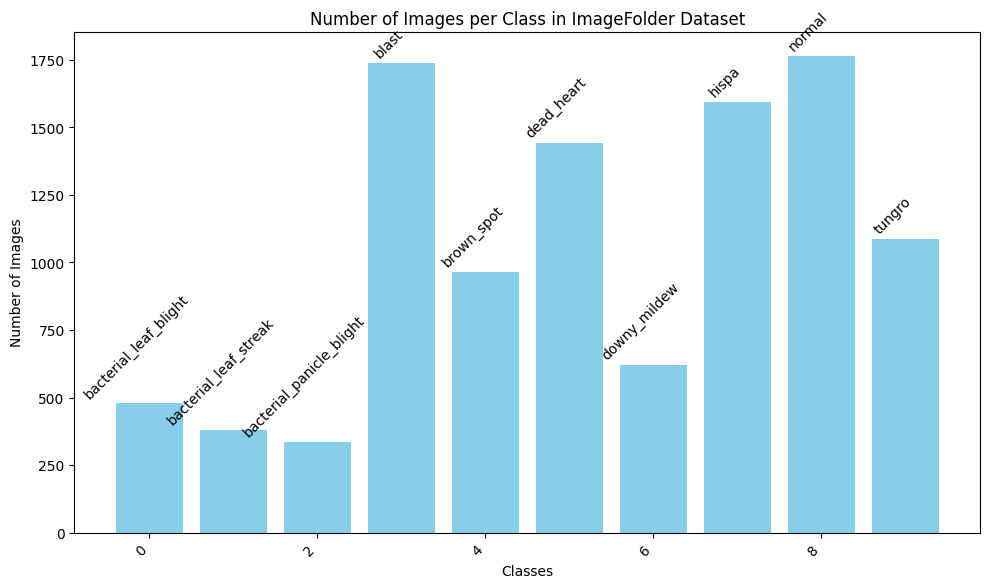

In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from collections import Counter


# Extract class labels and count the occurrences
class_labels = [class_idx for _, class_idx in train.imgs]
label_counts = Counter(class_labels)

# Extract class names
class_names = train.classes

# Extract data for plotting
classes = list(label_counts.keys())
counts = list(label_counts.values())

# Plotting the bar graph with class names on each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue')

# Add class names on each bar
for bar, class_name in zip(bars, class_names):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 20, class_name, rotation=45, ha='center')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in ImageFolder Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
'''
it is used for visualization purpose changes the normalized images to demoralized
FORMULA USED : output[channel] = (input[channel]*std[channel] + mean[channel])
its a reverse of the normalization
'''
def denorm(img_tensors):
    return img_tensors * NORMALIZATION_STATS[1][0] + NORMALIZATION_STATS[0][0]

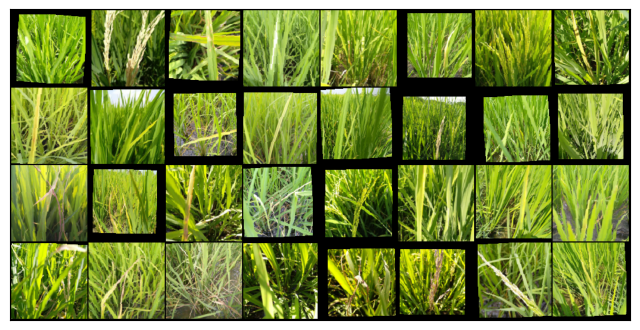

In [ ]:
#this plot the 64 images in 8x8 matrix
# subplot is used to plot multiple images in one frame
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [ ]:
#optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(resnet_model.parameters(), lr=lr)

#criterion = nn.CrossEntropyLoss()
#writer = SummaryWriter()
logs =  {"train_loss":[] ,"val_loss":[] , "val_acc":[]}

In [ ]:
_
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
#train_dl = DeviceDataLoader(train_dl,device)
#val_dl = DeviceDataLoader(val_dl,device)
model = to_device(model,device)

In [ ]:
from torchsummary import summary
summary(model,(3,IMAGE_SIZE,IMAGE_SIZE))

In [ ]:
def save_model(resnet_model,epoch,loss,logs):
    checkpoint_path = '/content/checkpoint'+str(epoch)+'.pth'
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': resnet_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,  # Add other relevant information as needed
    }
    torch.save(checkpoint, checkpoint_path)
    file_path = "/content/logs/paddy_classification_logs.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump(logs, file)
os.mkdir("/content/logs")

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model,val_loader):
    model.eval()
    loss = []
    acc = []
    for image ,label in val_loader:
        image, label = image.to(device), label.to(device)
        out = model(image)
        l = F.cross_entropy(out, label)
        a = accuracy(out, label)  # You need to implement the 'accuracy' function
        loss.append(l)
        acc.append(a)

    loss = torch.Tensor(loss).mean().item()
    acc = torch.Tensor(acc).mean().item()
    return loss, acc

for epoch in range(1 , EPOCHS+1):
    model.train()
    losses = []
    for image, label in tqdm.tqdm(train_dl):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())



    train_loss = torch.Tensor(losses).mean().item()
    val_loss , val_acc = evaluate(model,val_dl)
    print("Train loss : ",train_loss,"     ||    val loss  : " ,val_loss ,"    ||    val accuracy  : " ,val_acc)


    logs['train_loss'].append(train_loss)
    logs['val_acc'].append(val_acc)
    logs['val_loss'].append(val_loss)


    if epoch%10==0 :
        print("saving model and logs")
        save_model(model,epoch,train_loss,logs)

save_model(model,epoch,train_loss,logs)

  0%|          | 0/261 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 261/261 [00:46<00:00,  5.56it/s]


Train loss :  0.40923798084259033      ||    val loss  :  0.38671547174453735     ||    val accuracy  :  0.8802083134651184


100%|██████████| 261/261 [00:44<00:00,  5.82it/s]


Train loss :  0.3187154233455658      ||    val loss  :  0.34741246700286865     ||    val accuracy  :  0.8877840638160706


100%|██████████| 261/261 [00:44<00:00,  5.93it/s]


Train loss :  0.2648603320121765      ||    val loss  :  0.31369897723197937     ||    val accuracy  :  0.8982007503509521


100%|██████████| 261/261 [00:43<00:00,  6.04it/s]


Train loss :  0.20688115060329437      ||    val loss  :  0.2659786641597748     ||    val accuracy  :  0.9166666865348816


100%|██████████| 261/261 [00:43<00:00,  5.97it/s]


Train loss :  0.16945646703243256      ||    val loss  :  0.2577730715274811     ||    val accuracy  :  0.9133522510528564


100%|██████████| 261/261 [00:43<00:00,  6.05it/s]


Train loss :  0.1405162513256073      ||    val loss  :  0.20230278372764587     ||    val accuracy  :  0.939393937587738


100%|██████████| 261/261 [00:43<00:00,  6.01it/s]


Train loss :  0.13148649036884308      ||    val loss  :  0.1945786029100418     ||    val accuracy  :  0.9483901262283325


100%|██████████| 261/261 [00:43<00:00,  6.04it/s]


Train loss :  0.11035759747028351      ||    val loss  :  0.1891583651304245     ||    val accuracy  :  0.9450757503509521


100%|██████████| 261/261 [00:43<00:00,  5.97it/s]


Train loss :  0.1069389060139656      ||    val loss  :  0.2431032657623291     ||    val accuracy  :  0.9431818127632141


100%|██████████| 261/261 [00:44<00:00,  5.85it/s]


Train loss :  0.09066102653741837      ||    val loss  :  0.16717395186424255     ||    val accuracy  :  0.9554924368858337
saving model and logs


100%|██████████| 261/261 [00:56<00:00,  4.64it/s]


Train loss :  0.08802321553230286      ||    val loss  :  0.1891860067844391     ||    val accuracy  :  0.9488636255264282


100%|██████████| 261/261 [00:41<00:00,  6.21it/s]


Train loss :  0.08148105442523956      ||    val loss  :  0.1769452542066574     ||    val accuracy  :  0.9479166865348816


100%|██████████| 261/261 [00:43<00:00,  5.96it/s]


Train loss :  0.07328002154827118      ||    val loss  :  0.16915856301784515     ||    val accuracy  :  0.9517045617103577


100%|██████████| 261/261 [00:41<00:00,  6.31it/s]


Train loss :  0.07194309681653976      ||    val loss  :  0.15898482501506805     ||    val accuracy  :  0.955018937587738


100%|██████████| 261/261 [00:40<00:00,  6.40it/s]


Train loss :  0.07550471276044846      ||    val loss  :  0.1606622338294983     ||    val accuracy  :  0.9569128751754761


100%|██████████| 261/261 [00:41<00:00,  6.25it/s]


Train loss :  0.06814136356115341      ||    val loss  :  0.16438159346580505     ||    val accuracy  :  0.9493371248245239


100%|██████████| 261/261 [00:41<00:00,  6.29it/s]


Train loss :  0.06086161360144615      ||    val loss  :  0.15105244517326355     ||    val accuracy  :  0.9583333134651184


100%|██████████| 261/261 [00:41<00:00,  6.33it/s]


Train loss :  0.06018703803420067      ||    val loss  :  0.14762425422668457     ||    val accuracy  :  0.9611742496490479


100%|██████████| 261/261 [00:41<00:00,  6.23it/s]


Train loss :  0.057118602097034454      ||    val loss  :  0.14661507308483124     ||    val accuracy  :  0.9573863744735718


100%|██████████| 261/261 [00:42<00:00,  6.19it/s]


Train loss :  0.04812036454677582      ||    val loss  :  0.16880424320697784     ||    val accuracy  :  0.9460227489471436
saving model and logs


100%|██████████| 261/261 [00:41<00:00,  6.24it/s]


Train loss :  0.045086801052093506      ||    val loss  :  0.17044085264205933     ||    val accuracy  :  0.9498106241226196


100%|██████████| 261/261 [00:42<00:00,  6.21it/s]


Train loss :  0.043818339705467224      ||    val loss  :  0.18972013890743256     ||    val accuracy  :  0.951231062412262


100%|██████████| 261/261 [00:42<00:00,  6.21it/s]


Train loss :  0.05344747379422188      ||    val loss  :  0.1579519361257553     ||    val accuracy  :  0.9583333134651184


100%|██████████| 261/261 [00:42<00:00,  6.20it/s]


Train loss :  0.043068431317806244      ||    val loss  :  0.15489012002944946     ||    val accuracy  :  0.9554924368858337


100%|██████████| 261/261 [00:41<00:00,  6.23it/s]


Train loss :  0.041654180735349655      ||    val loss  :  0.16284847259521484     ||    val accuracy  :  0.9592803120613098


100%|██████████| 261/261 [00:41<00:00,  6.24it/s]


Train loss :  0.03746235743165016      ||    val loss  :  0.14309796690940857     ||    val accuracy  :  0.9621211886405945


100%|██████████| 261/261 [00:41<00:00,  6.28it/s]


Train loss :  0.035747841000556946      ||    val loss  :  0.1643674373626709     ||    val accuracy  :  0.9578598737716675


100%|██████████| 261/261 [00:41<00:00,  6.25it/s]


Train loss :  0.036235883831977844      ||    val loss  :  0.16301284730434418     ||    val accuracy  :  0.9616477489471436


100%|██████████| 261/261 [00:44<00:00,  5.84it/s]


Train loss :  0.03663575276732445      ||    val loss  :  0.16250400245189667     ||    val accuracy  :  0.9583333134651184


100%|██████████| 261/261 [00:46<00:00,  5.67it/s]


Train loss :  0.03725292161107063      ||    val loss  :  0.14362844824790955     ||    val accuracy  :  0.9621211886405945
saving model and logs


100%|██████████| 261/261 [00:46<00:00,  5.58it/s]


Train loss :  0.03200096637010574      ||    val loss  :  0.13633032143115997     ||    val accuracy  :  0.9673295617103577


100%|██████████| 261/261 [00:48<00:00,  5.42it/s]


Train loss :  0.030315512791275978      ||    val loss  :  0.1474912017583847     ||    val accuracy  :  0.9559659361839294


100%|██████████| 261/261 [00:45<00:00,  5.68it/s]


Train loss :  0.03305257484316826      ||    val loss  :  0.1498812586069107     ||    val accuracy  :  0.9602272510528564


100%|██████████| 261/261 [00:45<00:00,  5.76it/s]


Train loss :  0.03493156656622887      ||    val loss  :  0.15557941794395447     ||    val accuracy  :  0.9583333134651184


100%|██████████| 261/261 [00:44<00:00,  5.85it/s]


Train loss :  0.03308810293674469      ||    val loss  :  0.15723417699337006     ||    val accuracy  :  0.9621211886405945


100%|██████████| 261/261 [00:43<00:00,  5.96it/s]


Train loss :  0.02917124517261982      ||    val loss  :  0.1238548532128334     ||    val accuracy  :  0.9701704382896423


100%|██████████| 261/261 [00:43<00:00,  6.01it/s]


Train loss :  0.02981923334300518      ||    val loss  :  0.136240154504776     ||    val accuracy  :  0.9640151262283325


100%|██████████| 261/261 [00:42<00:00,  6.09it/s]


Train loss :  0.03215491399168968      ||    val loss  :  0.11753480136394501     ||    val accuracy  :  0.9673295617103577


100%|██████████| 261/261 [00:42<00:00,  6.13it/s]


Train loss :  0.028751537203788757      ||    val loss  :  0.17229068279266357     ||    val accuracy  :  0.9554924368858337


100%|██████████| 261/261 [00:42<00:00,  6.14it/s]


Train loss :  0.03012860380113125      ||    val loss  :  0.1533188670873642     ||    val accuracy  :  0.9621211886405945
saving model and logs


100%|██████████| 261/261 [00:42<00:00,  6.17it/s]


Train loss :  0.036268603056669235      ||    val loss  :  0.14292320609092712     ||    val accuracy  :  0.9625946879386902


100%|██████████| 261/261 [00:41<00:00,  6.27it/s]


Train loss :  0.03862568363547325      ||    val loss  :  0.16101685166358948     ||    val accuracy  :  0.9583333134651184


100%|██████████| 261/261 [00:42<00:00,  6.21it/s]


Train loss :  0.03530501201748848      ||    val loss  :  0.15682081878185272     ||    val accuracy  :  0.9569128751754761


100%|██████████| 261/261 [00:41<00:00,  6.25it/s]


Train loss :  0.025891415774822235      ||    val loss  :  0.12951026856899261     ||    val accuracy  :  0.9663825631141663


100%|██████████| 261/261 [00:41<00:00,  6.26it/s]


Train loss :  0.02513917349278927      ||    val loss  :  0.1374294012784958     ||    val accuracy  :  0.9630681872367859


100%|██████████| 261/261 [00:42<00:00,  6.20it/s]


Train loss :  0.03473641350865364      ||    val loss  :  0.13773225247859955     ||    val accuracy  :  0.9597538113594055


100%|██████████| 261/261 [00:42<00:00,  6.19it/s]


Train loss :  0.023122549057006836      ||    val loss  :  0.12741883099079132     ||    val accuracy  :  0.9659090638160706


100%|██████████| 261/261 [00:42<00:00,  6.16it/s]


Train loss :  0.02272837981581688      ||    val loss  :  0.14982865750789642     ||    val accuracy  :  0.9678030014038086


100%|██████████| 261/261 [00:40<00:00,  6.37it/s]


Train loss :  0.02135832980275154      ||    val loss  :  0.1474498063325882     ||    val accuracy  :  0.9640151262283325


100%|██████████| 261/261 [00:42<00:00,  6.20it/s]


Train loss :  0.02678583562374115      ||    val loss  :  0.13175265491008759     ||    val accuracy  :  0.9673295617103577
saving model and logs


In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
file_path = "/content/drive/MyDrive/models/logs/paddy_classification_logs.pkl"
with open(file_path, 'rb') as file:
    logs = pickle.load(file)

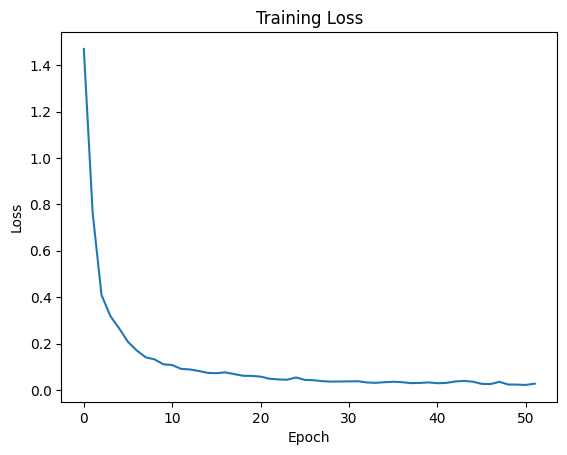

In [ ]:
# prompt: plot matplotlib loss vs epoch where loss is in logs['train_loss']
plt.plot(logs['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


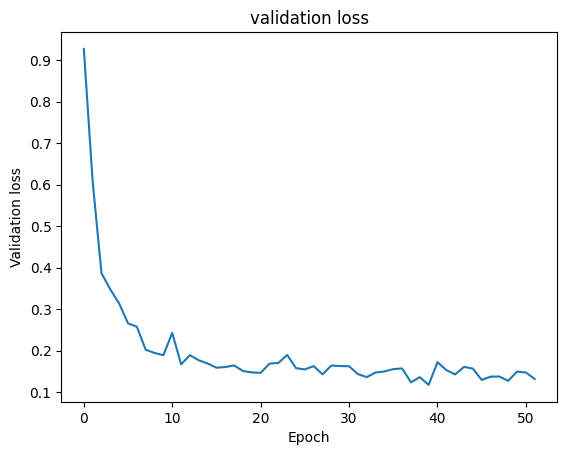

In [ ]:
# prompt: plot matplotlib loss vs epoch where loss is in logs['train_loss']
plt.plot(logs['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('validation loss')
plt.show()


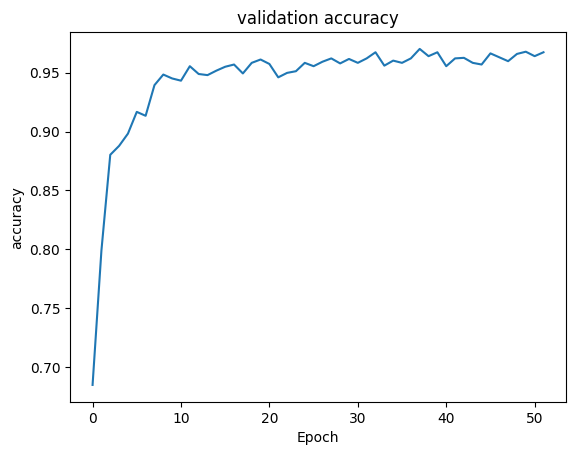

In [ ]:
# prompt: plot matplotlib loss vs epoch where loss is in logs['train_loss']
plt.plot(logs['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('validation accuracy')
plt.show()